In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Initial conditions

This notebook grew out of a problem: if I ran the notebooks `Grid and Space Sepp/With real data KDE.ipynb` and `Full/With real data.ipynb` then I got really different results!  This is problematic because the only difference between these models _should be_ the background estimator.

- I re-factored the KDE code to move it into its own package.  Thus the two models now use _exactly_ the same code.
- Below we find a new KDE provider which actually just implements a "grid based" background estimation.
- Hence the results _should_ be identical.

Eventually I traced the problem back to initial conditions-- the initial model used by `sepp_full` was not well-tuned to real data, and this made a huge difference.

This notebook hence exists for historical reasons; but it might be of interest to see how to debug model fitting.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_full
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout()
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, collections
import open_cp.predictors
import scipy.stats
import sepp.kernels

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")
    
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

# Plotting functions

In [4]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    def ker(pts):
        pts = np.asarray(pts)
        z = np.zeros(pts.shape[-1])
        return model.background(np.asarray([z,pts[0], pts[1]]))
    bpred = open_cp.predictors.grid_prediction_from_kernel(ker, grid.region(), grid.xsize)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    xy_marginal = sepp.kernels.compute_space_marginal(model.trigger_kernel)
    t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)
    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * t_marginal(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], xy_marginal, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

## New kernel provider

Use a grid, so this _should_ be identical to `sepp_grid_space.Model5`

In [5]:
class GridKernel():
    def __init__(self, grid, mu):
        self._mu = np.asarray(mu)
        self._grid = grid
        assert self._mu.shape == (grid.yextent, grid.xextent)
        self._region = tuple(self._grid.region())
        
    def __call__(self, pts):
        pts = np.asarray(pts)
        if len(pts.shape) <= 1:
            pts = pts[:,None]
        assert pts.shape[0] == 2
        m = (pts[0] >= self._region[0]) & (pts[1] >= self._region[1])
        m &= (pts[0] < self._region[2]) & (pts[1] < self._region[3])
        out = np.empty(pts.shape[1])
        out[~m] = 0
        gx, gy = self._grid.grid_coord(*pts[:,m])
        out[m] = self._mu[gy,gx]
        return out

mu = np.random.random((grid.yextent, grid.xextent))
gk = GridKernel(grid, mu)
assert gk([0,0]) == 0
assert gk([grid.xoffset, grid.yoffset]) == mu[0,0]
assert gk([grid.xoffset + grid.xsize, grid.yoffset]) == mu[0,1]
assert gk([grid.xoffset, grid.yoffset + grid.ysize]) == mu[1,0]
assert gk([grid.xoffset + 2 * grid.xsize, grid.yoffset + grid.ysize]) == mu[1,2]
np.testing.assert_allclose(gk([[0, grid.xoffset, grid.xoffset + 2 * grid.xsize],
                               [0, grid.yoffset, grid.yoffset + grid.ysize]]), [0, mu[0,0], mu[1,2]])
    
class GridEstimator(sepp.kernels.KernelProvider):
    def __init__(self, grid):
        self._grid = grid
        self._region = tuple(self._grid.region())
        
    def __call__(self, pts, weights):
        pts = np.asarray(pts)
        if len(pts.shape) <= 1:
            pts = pts[:,None]
        assert pts.shape[0] == 2
        m = (pts[0] >= self._region[0]) & (pts[1] >= self._region[1])
        m &= (pts[0] < self._region[2]) & (pts[1] < self._region[3])
        gx, gy = self._grid.grid_coord(*pts[:,m])

        mu = np.zeros((grid.yextent, grid.xextent))
        for p, x, y in zip(weights, gx, gy):
            mu[y,x] += p
        area = grid.xsize * grid.ysize
        mu = mu / (area * np.sum(mu))
        return GridKernel(self._grid, mu)

## Train with `sepp.sepp_grid_space.Trainer5`

This is the benchmark which we think is "correct".

In [18]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
trainer = sepp.sepp_grid_space.Trainer5(grid, kp, p_cutoff=99.99, initial_space_scale=100)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2017,1,1))

In [19]:
model = trainer.train(datetime.datetime(2017,1,1), iterations=20)
model

Model5(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.5405788170178519, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000245BA760898>

In [20]:
np.sum(model.mu * grid.xsize * grid.ysize)

1.5428768317478578

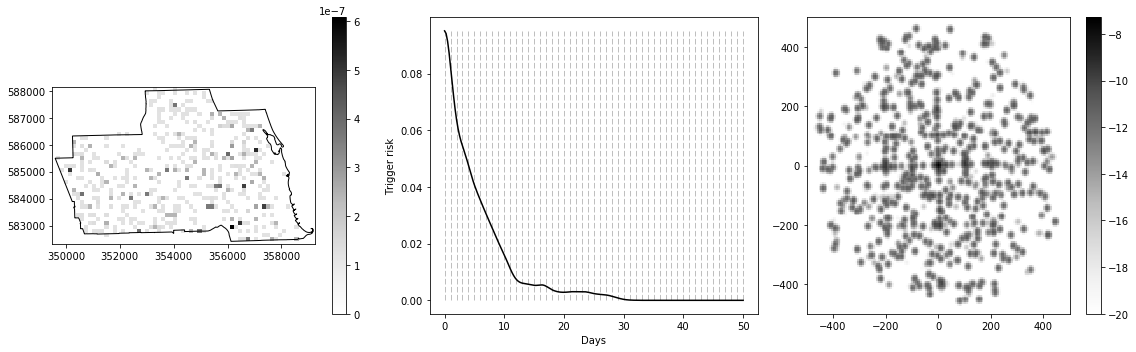

In [21]:
fig = plot(model, time_size=50, space_size=500, space_floor=np.exp(-20))

## Copy the initial condition across

Check that if we copy the initial `model` from one `trainer` to the other, we get the same output.  We do.  We also test some of this with, ahem, unit tests...

In [28]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
trainer = sepp.sepp_grid_space.Trainer5(grid, kp, p_cutoff=99.99, initial_space_scale=100)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2017,1,1))
model = trainer.initial_model(T, data)

In [29]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
back_ker_prov = GridEstimator(grid)
opt_fac = sepp.sepp_full.OptimiserFactory(back_ker_prov, kp)
trainer1 = sepp.sepp_full.Trainer(opt_fac, p_cutoff=99.99, initial_space_scale=100)
trainer1.data = points
T1, data1 = trainer1.make_data(datetime.datetime(2017,1,1))

model1 = model
for _ in range(19):
    opt1 = trainer1._optimiser(model1, data1)
    model1 = opt1.iterate()
model1

Model(T=365.9583333333333, mu=1.5451187807974625, background=<__main__.GridKernel object at 0x00000245BAFF4198>, theta=0.5399112336674763, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000245BA7AA518>

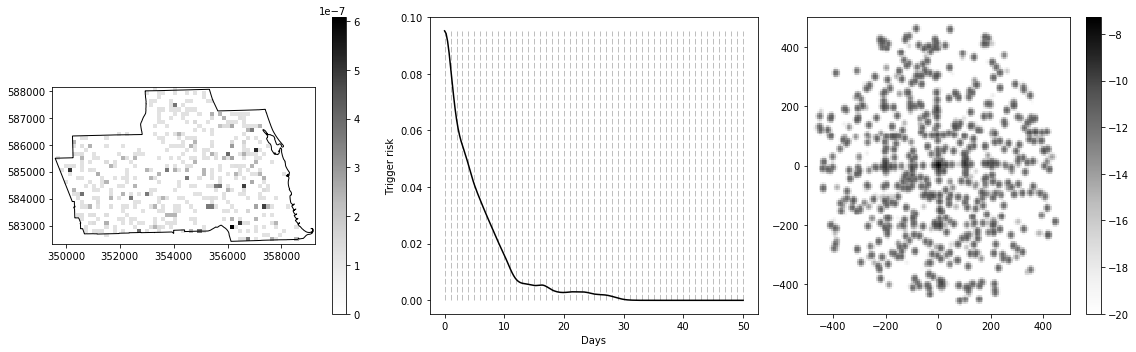

In [30]:
fig = plot(model1, time_size=50, space_size=500, space_floor=np.exp(-20))

## Compare initial models

In [50]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
trainer = sepp.sepp_grid_space.Trainer5(grid, kp, p_cutoff=99.99, initial_space_scale=100)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2017,1,1))
trainer1 = sepp.sepp_full.Trainer(opt_fac, p_cutoff=99.99, initial_space_scale=100)
trainer1.data = points
T1, data1 = trainer1.make_data(datetime.datetime(2017,1,1))

In [51]:
imodel = trainer.initial_model(T, data)
imodel1 = trainer1.initial_model(T1, data1)

In [52]:
assert imodel.T == imodel1.T
assert imodel.theta == imodel1.theta

In [53]:
pts = np.random.random((3,1000))

In [54]:
np.testing.assert_allclose(imodel.trigger_kernel(pts) * imodel.theta, imodel.trigger(None, pts))
np.testing.assert_allclose(imodel1.trigger_kernel(pts) * imodel1.theta, imodel1.trigger(None, pts))

In [57]:
np.testing.assert_allclose(imodel.trigger_kernel(pts), imodel1.trigger_kernel(pts))

## Train with `sepp.sepp_full.Trainer`

We set the initial bandwidths to be unrealistic (which used, ahem, to be the default).  Notice the somewhat different result...

In [58]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
#back_ker_prov = sepp.sepp_full.FixedBandwidthKernelProvider(100)
back_ker_prov = GridEstimator(grid)
opt_fac = sepp.sepp_full.OptimiserFactory(back_ker_prov, kp)
trainer1 = sepp.sepp_full.Trainer(opt_fac, p_cutoff=99.99, initial_time_scale=0.1, initial_space_scale=10)
trainer1.data = points
T1, data1 = trainer1.make_data(datetime.datetime(2017,1,1))

In [59]:
model1 = trainer1.train(datetime.datetime(2017,1,1), iterations=20)
model1

Model(T=365.9583333333333, mu=2.5750604717489463, background=<__main__.GridKernel object at 0x00000245B9EB1668>, theta=0.23322633159170758, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000245BB6E4518>

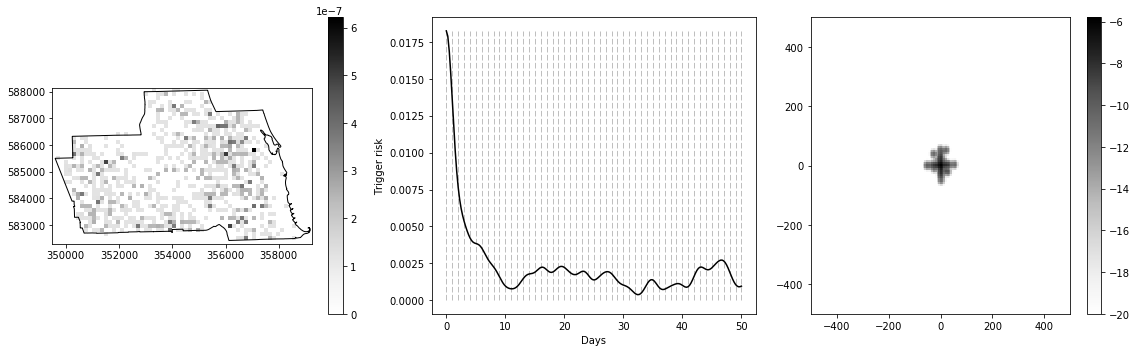

In [60]:
fig = plot(model1, time_size=50, space_size=500, space_floor=np.exp(-20))

# Train with different initial conditions

Matching those we used before.  Result is the same, fortunately.

In [61]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
#back_ker_prov = sepp.sepp_full.FixedBandwidthKernelProvider(100)
back_ker_prov = GridEstimator(grid)
opt_fac = sepp.sepp_full.OptimiserFactory(back_ker_prov, kp)
trainer1 = sepp.sepp_full.Trainer(opt_fac, p_cutoff=99.99, initial_space_scale=100)
trainer1.data = points
T1, data1 = trainer1.make_data(datetime.datetime(2017,1,1))

In [62]:
model1 = trainer1.train(datetime.datetime(2017,1,1), iterations=20)
model1

Model(T=365.9583333333333, mu=1.4484284653331942, background=<__main__.GridKernel object at 0x00000245BA3FC400>, theta=0.5687026304915432, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000245B9FCF208>

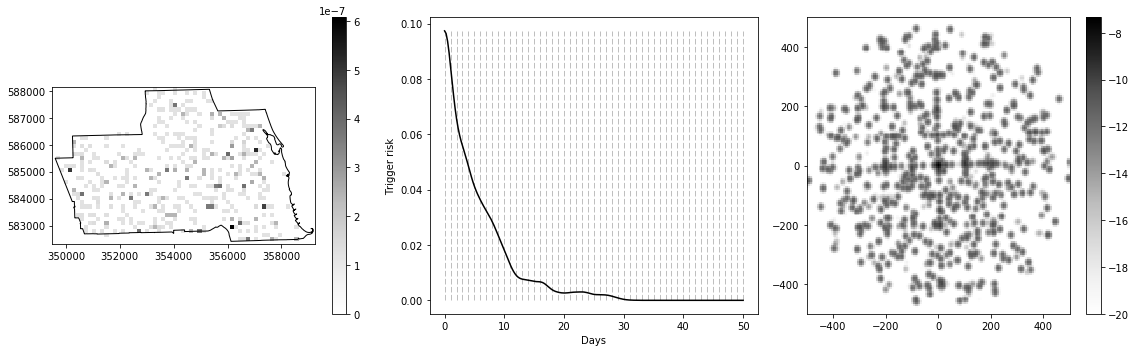

In [63]:
fig = plot(model1, time_size=50, space_size=500, space_floor=np.exp(-20))

## Do the "bad" initial conditions eventually converge?

No...!!

In [64]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
#back_ker_prov = sepp.sepp_full.FixedBandwidthKernelProvider(100)
back_ker_prov = GridEstimator(grid)
opt_fac = sepp.sepp_full.OptimiserFactory(back_ker_prov, kp)
trainer1 = sepp.sepp_full.Trainer(opt_fac, p_cutoff=99.99, initial_time_scale=0.1, initial_space_scale=10)
trainer1.data = points
T1, data1 = trainer1.make_data(datetime.datetime(2017,1,1))

In [65]:
model1 = trainer1.train(datetime.datetime(2017,1,1), iterations=50)
model1

Model(T=365.9583333333333, mu=2.5750540633151364, background=<__main__.GridKernel object at 0x00000245BB555DD8>, theta=0.23322823982584623, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000245C4F57438>

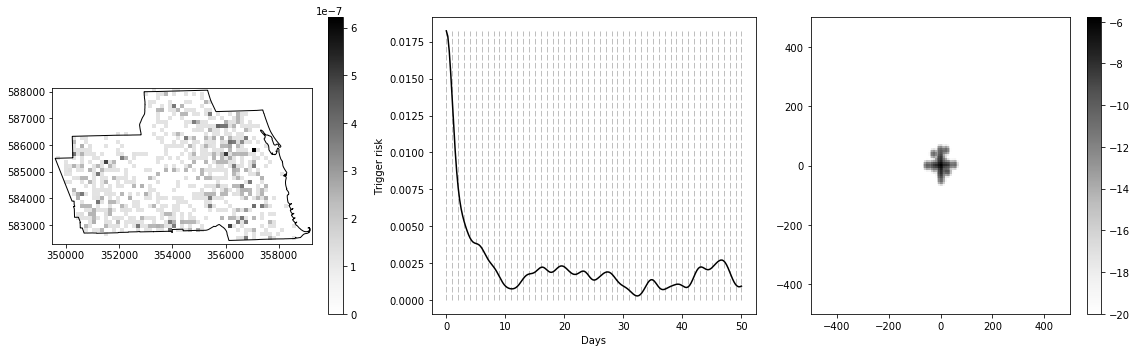

In [66]:
fig = plot(model1, time_size=50, space_size=500, space_floor=np.exp(-20))